In [32]:
import sys
sys.path.append('../')
sys.path.append('/Users/sdbykov/work/my_packages/nway')

In [33]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import fits_to_pandas, pandas_to_fits, assess_goodnes_nway_cross_match
import pandas as pd
import numpy as np
import seaborn as sns
import nway_python_api as nway
%matplotlib inline

In [34]:
desi_pandas_ph =  pd.read_pickle(data_path+'desi_lh.gz_pkl', compression = 'gzip')
tm_desi_id=desi_pandas_ph['release'].astype(str)+'_'+desi_pandas_ph['brickid'].astype(str)+'_'+desi_pandas_ph['objid'].astype(str)
desi_pandas_ph.columns = ['desi_'+x for x in desi_pandas_ph.columns]
desi_pandas_ph['nway_desi_id'] = tm_desi_id

erosita_orig_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl')
#set EROSITA as an index
erosita_orig_df['EROSITA'] = erosita_orig_df.index

In [35]:
ero_pandas = fits_to_pandas('ERO_lhpv_03_23_sd01_a15_g14.fits') #this catalog is used for nway cross-matching
ero_ctps_pandas = pd.read_pickle(data_path+'validation_ctps_ero_desi_lh.pkl')
ero_pandas = ero_pandas.merge(ero_ctps_pandas, on='ID', how='left')

nway_res = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_nway.pkl')
nway_res_dist_only = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_nway_distance_only.pkl')


In [37]:
def get_flag_num(x, flag):
    try:
        return x.value_counts()[flag]
    except:
        return 0

nway_res['n_match_flag_0'] = nway_res.groupby('EROSITA')['match_flag'].transform(lambda x: get_flag_num(x, 0))
nway_res['n_match_flag_2'] = nway_res.groupby('EROSITA')['match_flag'].transform(lambda x: get_flag_num(x, 2))
tmp = nway_res.groupby('EROSITA')['Separation_EROSITA_DESI'].transform(lambda x: min(x))
nway_res['is_closest'] = tmp == nway_res['Separation_EROSITA_DESI']
nway_res['is_within_pos_r98'] = nway_res['Separation_EROSITA_DESI'] < 2.79*nway_res['pos_err'] #2.79 if the coeff to transform pos_sigma2d (0.39 prob) into pos_r98 (0.98 prob) via  [0.98 = 1 - exp(-r^2/2) solve for r]. Assuming pos_err is the standard deviation of the position error (sigma 2d, 39% probability)




nway_res_dist_only['n_match_flag_0'] = nway_res_dist_only.groupby('EROSITA')['match_flag'].transform(lambda x: get_flag_num(x, 0))
nway_res_dist_only['n_match_flag_2'] = nway_res_dist_only.groupby('EROSITA')['match_flag'].transform(lambda x: get_flag_num(x, 2))
tmp = nway_res_dist_only.groupby('EROSITA')['Separation_EROSITA_DESI'].transform(lambda x: min(x))
nway_res_dist_only['is_closest'] = tmp == nway_res_dist_only['Separation_EROSITA_DESI']
nway_res_dist_only['is_within_pos_r98'] = nway_res_dist_only['Separation_EROSITA_DESI'] < 2.79*nway_res_dist_only['pos_err'] 


In [40]:
print(nway_res.query('match_flag == 1').groupby('is_closest')['is_within_pos_r98'].value_counts())
print(nway_res_dist_only.query('match_flag == 1').groupby('is_closest')['is_within_pos_r98'].value_counts())

is_closest  is_within_pos_r98
False       True                 1854
            False                 179
True        True                 7163
            False                 304
Name: is_within_pos_r98, dtype: int64
is_closest  is_within_pos_r98
True        True                 9124
            False                 376
Name: is_within_pos_r98, dtype: int64


# Duplicates check

In [41]:
def calc_ero_sep(df):
    ra1,dec1 = df[['RA', 'DEC']].values[0]
    ra2,dec2 = df[['RA', 'DEC']].values[1]
    dist =  3600*np.sqrt(((ra1-ra2)**2 + (dec1-dec2)**2))
    err1 = df['pos_err'].values[0]
    err2 = df['pos_err'].values[1]
    pos_err_factor_to_r68 = 1.51
    is_duplicated = (dist<pos_err_factor_to_r68*err1) or (dist<pos_err_factor_to_r68*err2) or (pos_err_factor_to_r68*err1>10) or (pos_err_factor_to_r68*err2>10) or (dist<pos_err_factor_to_r68*err1+pos_err_factor_to_r68*err2)
    is_confused = True
    return dist, is_duplicated, is_confused


nway_matches = nway_res.query('match_flag == 1') 
tmp_df_dup = nway_matches[nway_matches.duplicated(['DESI'], keep = False)].sort_values(['DESI', 'prob_has_match'])


ero_seps = tmp_df_dup.groupby('DESI').apply(calc_ero_sep)
ero_seps = pd.DataFrame(ero_seps.to_list(), columns=['ero_sep', 'is_duplicated' , 'is_confused'], index=ero_seps.index)
tmp_df_dup = tmp_df_dup.merge(ero_seps, left_on='DESI', right_index=True)




cols_check  = ['EROSITA', 'DESI', 'pos_err', 'Separation_EROSITA_DESI', 'ero_sep', 'prob_has_match', 'prob_this_match', 'is_duplicated', 'n_match_flag_2', 'n_match_flag_0', 'is_confused']
#add DET_LIKE_0, ML_COUNTS #TODO
nway_res = nway_res.merge(tmp_df_dup[['EROSITA', 'is_duplicated', 'is_confused']], on='EROSITA', how='left')
#replace NaNs in is_duplicated and is_confused with False
nway_res['is_duplicated'].fillna(False, inplace=True)
nway_res['is_confused'].fillna(False, inplace=True)

len(nway_res)


142704

In [42]:
tmp_df_dup.query('is_confused == 1')[cols_check].head(10)
#DET LIKE, counts, flux..., EXTENDED_LIKE, 

,EROSITA,DESI,pos_err,Separation_EROSITA_DESI,ero_sep,prob_has_match,prob_this_match,is_duplicated,n_match_flag_2,n_match_flag_0,is_confused
1040,491,8,3.026402,0.990467,1.688599,0.991273,0.936894,True,0,5,True
1039,46,8,0.872304,0.638856,1.688599,0.999025,1.000000,True,0,5,True
477,186,824,5.200615,8.410066,9.008319,0.929577,0.779972,True,0,18,True
476,20,824,0.889574,0.612573,9.008319,0.999019,0.998348,True,0,16,True
1781,84,2520,11.221201,1.350954,2.293356,0.807001,0.794255,True,0,11,True
1782,281,2520,1.174026,1.388583,2.293356,0.993443,1.000000,True,0,11,True
702,30,6158,2.640228,3.867884,5.919639,0.923280,1.000000,True,0,8,True
703,896,6158,2.085830,2.262885,5.919639,0.969013,1.000000,True,0,7,True
12580,3851,6460,20.204395,18.242825,21.031950,0.686495,0.766040,True,0,12,True
12579,694,6460,3.689198,2.549289,21.031950,0.983481,0.999982,True,0,9,True


In [43]:
tmp_df_dup.query('is_duplicated == 0').sort_values(['DESI', 'Separation_EROSITA_DESI'], ascending=True)[cols_check]

,EROSITA,DESI,pos_err,Separation_EROSITA_DESI,ero_sep,prob_has_match,prob_this_match,is_duplicated,n_match_flag_2,n_match_flag_0,is_confused
0,0,10477,0.802682,0.042512,7.162810,0.999364,1.000000,False,0,17,True
1,42,10477,3.901622,6.767775,7.162810,0.937712,0.998151,False,0,11,True
111,5,11901,0.802730,1.088955,7.053517,0.998482,0.966452,False,0,12,True
112,143,11901,3.162606,2.512251,7.053517,0.987279,0.966608,False,0,13,True
180,9,14505,0.815951,0.223990,8.577102,0.999342,0.966763,False,0,13,True
181,146,14505,3.294812,7.485849,8.577102,0.891643,0.873548,False,0,13,True
42643,6494,263221,3.133535,0.919903,28.244446,0.976337,0.994978,False,0,17,True
42642,2582,263221,3.028244,14.858204,28.244446,0.000390,0.704780,False,0,21,True
48675,2982,763798,2.379024,2.160583,9.232512,0.868551,0.999357,False,0,11,True
48676,3747,763798,2.180482,8.531008,9.232512,0.005819,0.976702,False,0,10,True


In [44]:
print(nway_res[nway_res.match_flag==1].is_confused.value_counts())
print(nway_res[nway_res.match_flag==1].is_duplicated.value_counts())

False    9452
True       48
Name: is_confused, dtype: int64
False    9462
True       38
Name: is_duplicated, dtype: int64


# Completeness/purity analysis

In [54]:
print((1854+179)/(1854+179+7163+304))
print(77/(77+569))

0.214
0.11919504643962849


In [58]:
print(nway_res.query('desi_id == desi_id_true_ctp & is_within_pos_r98 == 1').is_closest.value_counts())


True     577
False    100
Name: is_closest, dtype: int64


In [59]:
100/(677)

0.14771048744460857

In [50]:
print(nway_res.query('match_flag==1 & desi_id==desi_id_true_ctp & ~desi_id_true_ctp.isna() & is_within_pos_r98 == 1').is_closest.value_counts())
print(nway_res.query('match_flag==1 & desi_id!=desi_id_true_ctp & ~desi_id_true_ctp.isna() & is_within_pos_r98 == 1').is_closest.value_counts())
print(nway_res.query('match_flag==1 & desi_id==desi_id_true_ctp & ~desi_id_true_ctp.isna() & is_within_pos_r98 == 0').is_closest.value_counts())
print(nway_res.query('match_flag==1 & desi_id!=desi_id_true_ctp & ~desi_id_true_ctp.isna() & is_within_pos_r98 == 0').is_closest.value_counts())

True     569
False     77
Name: is_closest, dtype: int64
True     19
False    12
Name: is_closest, dtype: int64
Series([], Name: is_closest, dtype: int64)
Series([], Name: is_closest, dtype: int64)


NWAY PERFOMANCE ON THE VALIDATION CATALOG
Completeness and purity for nway matching 
completeness = fraction of sources with prob_has_match > p 
purity = fraction of sources with prob_has_match > p and correct nway assignment
 Completeness = 96% 
 Purity = 96% 
 prob_has_match optimal cutoff =  0.39 
 Fraction of sources with prob_has_match > 0.39 = 83%
+++Statistics+++
677 X-ray sources in validation set with counterparts
--Out of those, 28 sources were assigned hostless (prob_has_match < 0.39) 
649 sources have prob_has_match > 0.39
Out of those 649: 
--622 sources have correct nway counterpart
--27 sources have incorrect nway counterpart
NWAY PERFOMANCE ON THE VALIDATION CATALOG
Completeness and purity for nway matching 
completeness = fraction of sources with prob_has_match > p 
purity = fraction of sources with prob_has_match > p and correct nway assignment
 Completeness = 85% 
 Purity = 85% 
 prob_has_match optimal cutoff =  0.63 
 Fraction of sources with prob_has_match > 0.63 =

Text(0.5, 0.98, 'XMM/CHANDRA Lockman Hole validation catalog')

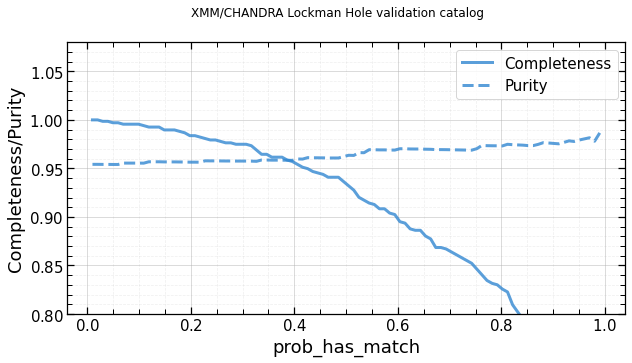

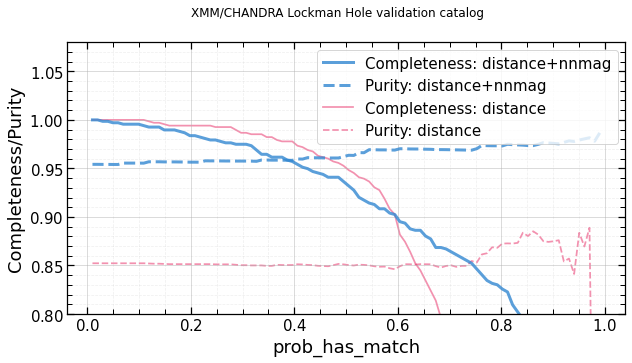

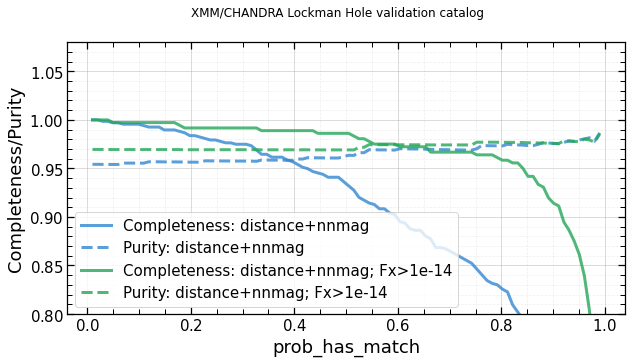

In [45]:
cutoff_intersection_nnmag, completeness_intersection_nnmag,  cutoffs_nnmag, completeness_nnmag, purity_nnmag = assess_goodnes_nway_cross_match(nway_res, plot_res=False)
cutoff_intersection_dist_only, completeness_intersection_dist_only,  cutoffs_dist_only, completeness_dist_only, purity_dist_only = assess_goodnes_nway_cross_match(nway_res_dist_only, plot_res=False)


plt.figure(figsize=(10,5))

plt.plot(cutoffs_nnmag, completeness_nnmag, 'C0-', lw = 3, alpha = 0.8, label=f'Completeness')
plt.plot(cutoffs_nnmag, purity_nnmag, 'C0--', lw = 3,  alpha = 0.8, label=f'Purity')

plt.legend()
plt.ylim(0.8,1.08)
plt.xlabel('prob_has_match')
plt.grid(visible=True, which='major', linestyle='-', alpha = 0.6)
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.2)
plt.ylabel('Completeness/Purity')
plt.suptitle('XMM/CHANDRA Lockman Hole validation catalog')


plt.figure(figsize=(10,5))

plt.plot(cutoffs_nnmag, completeness_nnmag, 'C0-', lw = 3, alpha = 0.8, label=f'Completeness: distance+nnmag')
plt.plot(cutoffs_nnmag, purity_nnmag, 'C0--', lw = 3,  alpha = 0.8, label=f'Purity: distance+nnmag')

plt.plot(cutoffs_dist_only, completeness_dist_only, 'C1-', alpha = 0.5, label=f'Completeness: distance', zorder = -1)
plt.plot(cutoffs_dist_only, purity_dist_only, 'C1--', alpha = 0.5, label=f'Purity: distance', zorder = -1)

plt.legend()
plt.ylim(0.8,1.08)
plt.xlabel('prob_has_match')
plt.grid(visible=True, which='major', linestyle='-', alpha = 0.6)
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.2)
plt.ylabel('Completeness/Purity')
plt.suptitle('XMM/CHANDRA Lockman Hole validation catalog')



plt.figure(figsize=(10,5))


cutoff_intersection_nnmag_bright, completeness_intersection_nnmag_bright,  cutoffs_nnmag_bright, completeness_nnmag_bright, purity_nnmag_bright = assess_goodnes_nway_cross_match(nway_res[nway_res.ML_FLUX_0>1e-14], plot_res=False)

plt.plot(cutoffs_nnmag, completeness_nnmag, 'C0-', lw = 3, alpha = 0.8, label=f'Completeness: distance+nnmag')
plt.plot(cutoffs_nnmag, purity_nnmag, 'C0--', lw = 3,  alpha = 0.8, label=f'Purity: distance+nnmag')


plt.plot(cutoffs_nnmag_bright, completeness_nnmag_bright, 'C2-', lw = 3, alpha = 0.8, label=f'Completeness: distance+nnmag; Fx>1e-14')
plt.plot(cutoffs_nnmag_bright, purity_nnmag_bright, 'C2--', lw = 3,  alpha = 0.8, label=f'Purity: distance+nnmag; Fx>1e-14')

plt.legend()
plt.ylim(0.8,1.08)
plt.xlabel('prob_has_match')
plt.grid(visible=True, which='major', linestyle='-', alpha = 0.6)
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.2)
plt.ylabel('Completeness/Purity')
plt.suptitle('XMM/CHANDRA Lockman Hole validation catalog')


# Plot distribution of nnmags for good matches with validation catalog

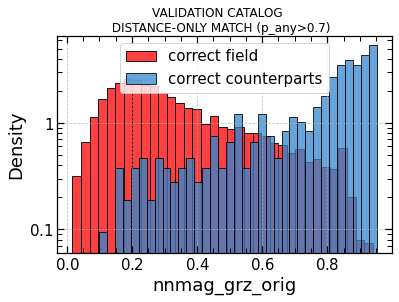

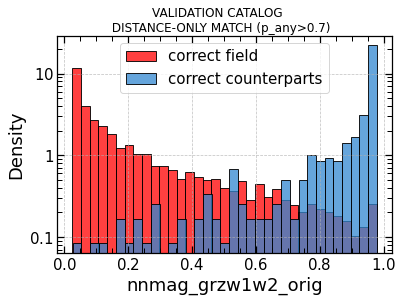

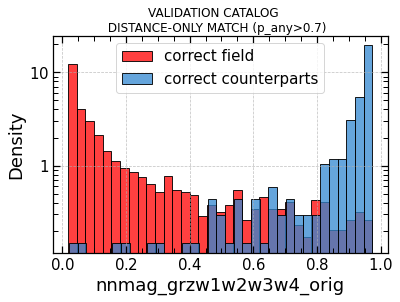

In [51]:
for prior_type in ['grz_orig', 'grzw1w2_orig', 'grzw1w2w3w4_orig']:
    prob_cutoff = 0.7
    plt.figure()
    sns.histplot(nway_res_dist_only.query(f"prob_has_match>@prob_cutoff & match_flag==0 & nnmag_{prior_type}!=-99. & ~desi_id_true_ctp.isnull()")['nnmag_'+prior_type], stat = 'density', color = 'r', bins = 35, label = 'correct field')
    sns.histplot(nway_res_dist_only.query(f"prob_has_match>@prob_cutoff & match_flag==1 & nnmag_{prior_type}!=-99. & desi_id==desi_id_true_ctp")['nnmag_'+prior_type], stat = 'density', bins = 35, label = 'correct counterparts')
    plt.suptitle(f'VALIDATION CATALOG \n DISTANCE-ONLY MATCH (p_any>{prob_cutoff})')
    plt.yscale('log')
    plt.legend()

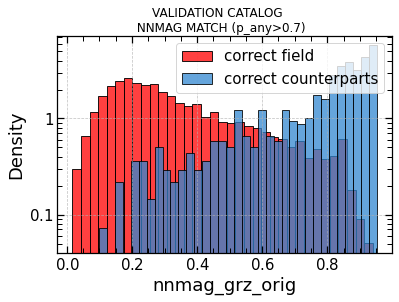

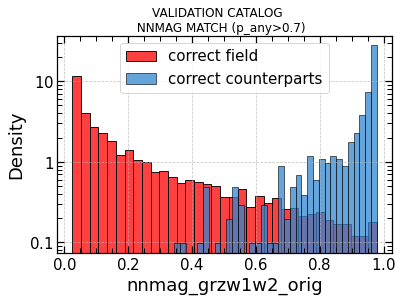

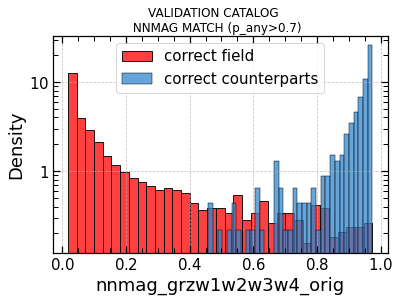

In [52]:
for prior_type in ['grz_orig', 'grzw1w2_orig', 'grzw1w2w3w4_orig']:
    prob_cutoff = 0.7
    plt.figure()
    sns.histplot(nway_res.query(f"prob_has_match>@prob_cutoff & match_flag==0 & nnmag_{prior_type}!=-99. & ~desi_id_true_ctp.isnull()")['nnmag_'+prior_type], stat = 'density', color = 'r', bins = 35, label = 'correct field')
    sns.histplot(nway_res.query(f"prob_has_match>@prob_cutoff & match_flag==1 & nnmag_{prior_type}!=-99. & desi_id==desi_id_true_ctp")['nnmag_'+prior_type], stat = 'density', bins = 35, label = 'correct counterparts')
    plt.suptitle(f'VALIDATION CATALOG \n NNMAG MATCH (p_any>{prob_cutoff})')
    plt.yscale('log')
    plt.legend()

# Separations between best matches and erosita 

544 objects with p_any>0.8


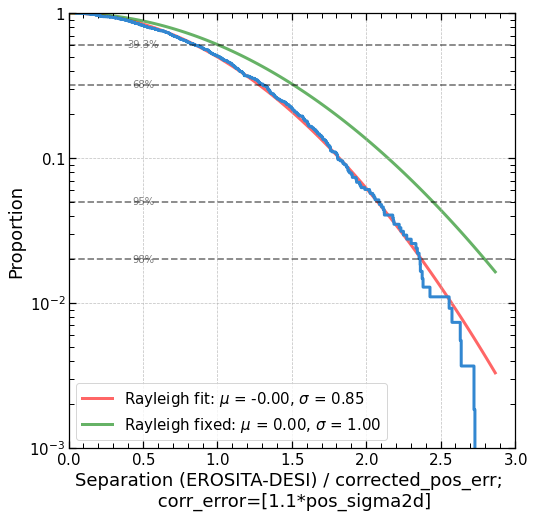

In [31]:
from scipy import stats
prob_cutoff = 0.8
#ero_ctps_tmp = nway_res.query(f"prob_has_match>@prob_cutoff & match_flag==1 & ~desi_id_true_ctp.isna()")
ero_ctps_tmp = nway_res.query(f"prob_has_match>@prob_cutoff & match_flag==1 & desi_id_true_ctp==desi_id")
print(f'{len(ero_ctps_tmp)} objects with p_any>{prob_cutoff}')
fig,  ax =  plt.subplots( figsize = (8,8))
pos_err = ero_ctps_tmp.pos_err/1.1
corrected_pos_err = pos_err

rat = ero_ctps_tmp.Separation_EROSITA_DESI/corrected_pos_err

corr_error_str = '[1.1*pos_sigma2d]'
rayleigh_fit = stats.rayleigh.fit(rat)
#sns.histplot(ero_ctps_tmp, x = rat, bins=50, stat = 'density', ax = ax)
sns.ecdfplot(ero_ctps_tmp, x = rat, ax = ax, complementary = True, lw = 3)

for prob in [39.3, 68, 95, 98]:
    plt.axhline(1 - prob/100, color = 'k', ls = '--', alpha = 0.5)
    plt.text(0.5, 1 - prob/100, f'{prob}%', ha = 'center', va = 'center', color = 'k', alpha = 0.5)


#plot the fit
x = np.linspace(0, rat.max()*1.05, 100)
ax.plot(x, 1-stats.rayleigh.cdf(x, *rayleigh_fit), 'r-', lw=3, alpha=0.6, label='Rayleigh fit: '+'$\mu$ = %.2f, $\sigma$ = %.2f' % rayleigh_fit, zorder = -1)
ax.plot(x, 1-stats.rayleigh.cdf(x, 0,1), 'g-', lw=3, alpha=0.6, label='Rayleigh fixed: '+'$\mu$ = %.2f, $\sigma$ = %.2f' % (0,1), zorder = -1)
ax.set(ylim=(1e-3, 1), xlim=(0, 3))
plt.legend()
plt.xlabel('Separation (EROSITA-DESI) / corrected_pos_err; \n '+ 'corr_error='+corr_error_str)
plt.yscale('log')

5787 objects with p_any>0.8


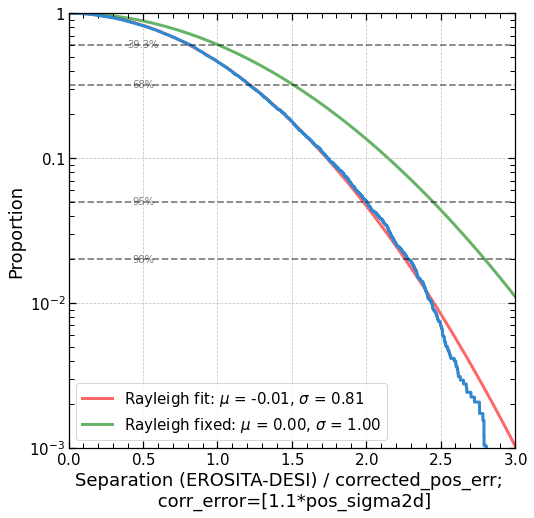

In [32]:
from scipy import stats
prob_cutoff = 0.8
ero_ctps_tmp = nway_res.query(f"prob_has_match>@prob_cutoff & match_flag==1") #TODO prob_cutoff impact on the fit
print(f'{len(ero_ctps_tmp)} objects with p_any>{prob_cutoff}')
fig,  ax =  plt.subplots( figsize = (8,8))
pos_err = ero_ctps_tmp.pos_err
corrected_pos_err = pos_err

rat = ero_ctps_tmp.Separation_EROSITA_DESI/corrected_pos_err

corr_error_str = '[1.1*pos_sigma2d]'
rayleigh_fit = stats.rayleigh.fit(rat)
#sns.histplot(ero_ctps_tmp, x = rat, bins=50, stat = 'density', ax = ax)
sns.ecdfplot(ero_ctps_tmp, x = rat, ax = ax, complementary = True, lw = 3)

for prob in [39.3, 68, 95, 98]:
    plt.axhline(1 - prob/100, color = 'k', ls = '--', alpha = 0.5)
    plt.text(0.5, 1 - prob/100, f'{prob}%', ha = 'center', va = 'center', color = 'k', alpha = 0.5)


#plot the fit
x = np.linspace(0, rat.max()*1.05, 100)
ax.plot(x, 1-stats.rayleigh.cdf(x, *rayleigh_fit), 'r-', lw=3, alpha=0.6, label='Rayleigh fit: '+'$\mu$ = %.2f, $\sigma$ = %.2f' % rayleigh_fit, zorder = -1)
ax.plot(x, 1-stats.rayleigh.cdf(x, 0,1), 'g-', lw=3, alpha=0.6, label='Rayleigh fixed: '+'$\mu$ = %.2f, $\sigma$ = %.2f' % (0,1), zorder = -1)
ax.set(ylim=(1e-3, 1), xlim=(0, 3))
plt.legend()
plt.xlabel('Separation (EROSITA-DESI) / corrected_pos_err; \n '+ 'corr_error='+corr_error_str)
plt.yscale('log')

5787 objects with p_any>0.8


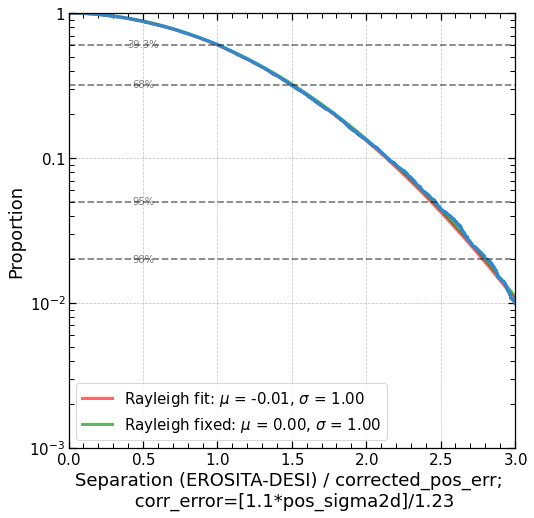

In [33]:
from scipy import stats
prob_cutoff = 0.8
ero_ctps_tmp = nway_res.query(f"prob_has_match>@prob_cutoff & match_flag==1")
print(f'{len(ero_ctps_tmp)} objects with p_any>{prob_cutoff}')
fig,  ax =  plt.subplots( figsize = (8,8))
pos_err = ero_ctps_tmp.pos_err
corrected_pos_err = pos_err/1.23

rat = ero_ctps_tmp.Separation_EROSITA_DESI/corrected_pos_err

corr_error_str = '[1.1*pos_sigma2d]/1.23'
rayleigh_fit = stats.rayleigh.fit(rat)
#sns.histplot(ero_ctps_tmp, x = rat, bins=50, stat = 'density', ax = ax)
sns.ecdfplot(ero_ctps_tmp, x = rat, ax = ax, complementary = True, lw = 3)

for prob in [39.3, 68, 95, 98]:
    plt.axhline(1 - prob/100, color = 'k', ls = '--', alpha = 0.5)
    plt.text(0.5, 1 - prob/100, f'{prob}%', ha = 'center', va = 'center', color = 'k', alpha = 0.5)


#plot the fit
x = np.linspace(0, rat.max()*1.05, 100)
ax.plot(x, 1-stats.rayleigh.cdf(x, *rayleigh_fit), 'r-', lw=3, alpha=0.6, label='Rayleigh fit: '+'$\mu$ = %.2f, $\sigma$ = %.2f' % rayleigh_fit, zorder = -1)
ax.plot(x, 1-stats.rayleigh.cdf(x, 0,1), 'g-', lw=3, alpha=0.6, label='Rayleigh fixed: '+'$\mu$ = %.2f, $\sigma$ = %.2f' % (0,1), zorder = -1)
ax.set(ylim=(1e-3, 1), xlim=(0, 3))
plt.legend()
plt.xlabel('Separation (EROSITA-DESI) / corrected_pos_err; \n '+ 'corr_error='+corr_error_str)
plt.yscale('log')

# Look a few  Individual cases with validation catalog

In [ ]:
test_columns_explain = ['Separation_EROSITA_DESI', 'pos_err',
       'match_flag', 'prob_has_match', 'prob_this_match',
       'ID', 'desi_id_true_ctp', 'desi_id', 'prior_type', 'nnmag_grzw1w2w3w4',
       'nnmag_grzw1w2', 'nnmag_grz', ]

explain_args = {'primary_id_col':'EROSITA', 'cols_ra' : ['RA', 'ra'], 'cols_dec':['DEC', 'dec'], 'cols_err': ['pos_err', 'desi_pos_err'], 'tablenames': ['EROSITA', 'DESI']}

In [34]:
#join three tables on EROSITA, DESI columns into one with appropriate suffixes
nway_res_concat = nway_res.merge(nway_res_dist_only[['EROSITA', 'DESI', 'p_single',	'match_flag',	'prob_has_match',	'prob_this_match',]], on=['EROSITA', 'DESI'], suffixes=['_nnmag', '_dist_only'], how='left')

In [35]:
nway_res_concat.query('~desi_id_true_ctp.isnull() &  match_flag_nnmag == 1 & match_flag_dist_only==0').sort_values('prob_has_match_nnmag').head(10)

,EROSITA,DESI,Separation_EROSITA_DESI,Separation_max,ncat,dist_bayesfactor_uncorrected,dist_bayesfactor,dist_post,bias_DESI_nnmag_grz,bias_DESI_nnmag_grzw1w2,bias_DESI_nnmag_grzw1w2w3w4,p_single_nnmag,match_flag_nnmag,prob_has_match_nnmag,prob_this_match_nnmag,ID,RA,DEC,pos_err,ML_FLUX_0,desi_id_true_ctp,desi_id,ra,dec,mag_g,mag_r,mag_z,mag_w1,mag_w2,mag_w3,mag_w4,col_gr,col_rz,col_gz,col_zw1,col_rw2,col_w1w2,col_zw3,col_rw4,col_w3w4,prior_type,nnmag_grzw1w2w3w4,nnmag_grzw1w2w3w4_orig,nnmag_grzw1w2,nnmag_grzw1w2_orig,nnmag_grz,nnmag_grz_orig,mag_g_orig,mag_r_orig,mag_z_orig,mag_w1_orig,mag_w2_orig,mag_w3_orig,mag_w4_orig,col_gr_orig,col_rz_orig,col_gz_orig,col_zw1_orig,col_rw2_orig,col_w1w2_orig,col_zw3_orig,col_rw4_orig,col_w3w4_orig,n_match_flag_0,n_match_flag_2,is_duplicated,is_confused,p_single_dist_only,match_flag_dist_only,prob_has_match_dist_only,prob_this_match_dist_only
103056,6748,930297,5.423450,5.423450,2,9.280715,9.280715,0.443901,1.000000,1.000000,0.091195,0.067856,1,0.117411,0.547211,b'SRGe J105322.6+580411',163.344120,58.069768,3.086368,5.222490e-15,b'9011_611495_2267',b'9011_611495_2254',163.343857,58.071268,-99.0,-99.0,-99.0,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.000000,-99.000000,-99.0,b'grzw1w2w3w4',0.103584,0.103584,-99.000000,0.106255,-99.000000,0.319987,23.503962,24.579212,23.890669,23.532236,22.073666,18.316559,16.632706,-1.075250,0.688543,-0.386707,0.358433,2.505546,1.458570,5.574110,7.946506,1.683853,14,1,False,False,0.443901,0,0.743973,0.274702
122165,8069,1104223,10.521675,10.521675,2,8.296461,8.296461,0.076444,1.000000,1.000000,1.697984,0.123226,1,0.147421,0.812812,b'SRGe J104015.1+585810',160.063042,58.969508,4.145544,4.118876e-15,b'9011_614513_2732',b'9011_614513_2732',160.068421,58.968584,-99.0,-99.0,-99.0,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.000000,-99.000000,-99.0,b'grzw1w2w3w4',0.670476,0.670476,-99.000000,0.733637,-99.000000,0.576137,23.681646,22.410942,20.716150,19.050180,19.259829,17.551338,16.017080,1.270704,1.694792,2.965496,1.665970,3.151113,-0.209649,3.164812,6.393862,1.534258,15,0,False,False,0.076444,0,0.398662,0.124851
121326,8013,2307960,8.689488,8.689488,2,8.805147,8.805147,0.210755,1.000000,1.000000,0.795787,0.175259,1,0.286838,0.528342,b'SRGe J104221.5+583805',160.589622,58.634642,4.448720,4.156313e-15,b'9011_613766_2125',b'9011_613766_2125',160.590481,58.637014,-99.0,-99.0,-99.0,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.000000,-99.000000,-99.0,b'grzw1w2w3w4',0.516168,0.516168,-99.000000,0.723031,-99.000000,0.167621,26.159643,23.707527,22.533610,19.952915,19.509096,17.734705,16.485453,2.452116,1.173917,3.626033,2.580695,4.198431,0.443819,4.798905,7.222074,1.249252,13,0,False,False,0.210755,0,0.692113,0.118790
84878,5512,1662312,7.558949,7.558949,2,8.795259,8.795259,0.206993,1.000000,1.049075,1.000000,0.214967,1,0.315503,0.594091,b'SRGe J103254.1+574157',158.225618,57.699169,3.402884,6.539371e-15,b'9011_610715_1032',b'9011_610715_1032',158.224534,57.697151,-99.0,-99.0,-99.0,-99.000000,-99.000000,-99.000000,-99.000000,-99.0,-99.0,-99.0,-99.000000,-99.000000,-99.0,-99.000000,-99.000000,-99.0,b'grzw1w2',-99.000000,-99.000000,0.468782,0.468782,-99.000000,0.173176,24.212114,24.320648,23.396347,20.713373,20.315891,NaN,NaN,-0.108534,0.924301,0.815767,2.682974,4.004757,0.397482,NaN,NaN,NaN,14,1,False,False,0.206993,0,0.638446,0.147818
116515,7682,338739,6.636129,6.636129,2,8.839927,8.839927,0.224385,1.260573,1.000000,1.000000,0.267229,1,0.318399,0.780680,b'SRGe J105545.0+573103',163.937381,57.517519,2.842618,4.427510e-15,b'9011_609952_907',b'9011_609952_907',163.938112,57.519320,-99.0,-99.0,-99.0,0.658917,-99.000000,0.507161,-99.000000,-99.0,-99.0,-99.0,-0.016787,-99.000000,-99.0,0.514361,-99.000000,-99.0,b'grz',-99.000000,-99.000000,-99.000000,-99.000000,0.531607,0.531607,22.357098,22.570377,22.894236,23.062110,NaN,17.750628,

NWAY results for Source 6748:

It is uncertain if this source has a counterpart (p_any=0.12)

Assuming it has a counterpart, we have the following possible associations:

Disclaimer: These results assume that the input (sky densities, positional errors, and priors) are correct.



,Separation_EROSITA_DESI,pos_err,match_flag,prob_has_match,prob_this_match,ID,desi_id_true_ctp,desi_id,prior_type,nnmag_grzw1w2w3w4,nnmag_grzw1w2,nnmag_grz
103056,5.423450,3.086368,1,0.117411,0.547211,b'SRGe J105322.6+580411',b'9011_611495_2267',b'9011_611495_2254',b'grzw1w2w3w4',0.103584,-99.0,-99.000000
103057,3.303668,3.086368,2,0.117411,0.448251,b'SRGe J105322.6+580411',b'9011_611495_2267',b'9011_611495_2267',b'grzw1w2w3w4',0.021495,-99.0,-99.000000
103058,12.069610,3.086368,0,0.117411,0.004488,b'SRGe J105322.6+580411',b'9011_611495_2267',b'9011_611495_2236',b'grz',-99.000000,-99.0,0.224503


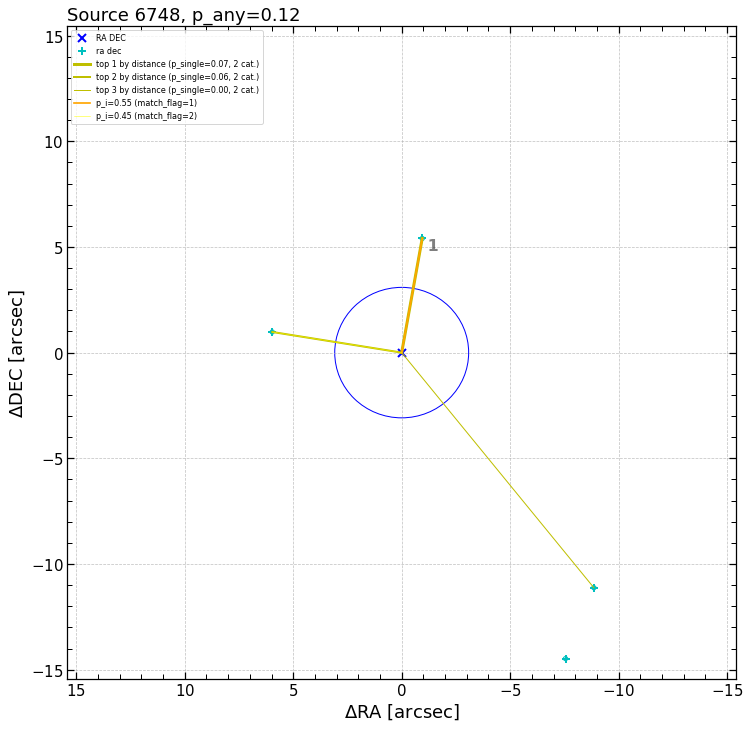

In [36]:
import nway_python_api as nway

ero_id = 6748
#774 - expected perfomance of nnmags: true ctps is not the closest but has a large nnmag_grzw1w2  -> unambiguous correct match
#5115 -example when true ctps has low grzw1w2, and a field source on the same separation has a moderate nnmag_grzw1w2w3w4 -> wrong association
#6748 -example when the closest is a true ctps, but NNMAG is low for him, hence nnmag assigns other DESI source as a counterpart. p_any is low for nnmag and high for distance-only
nway.explain(nway_res, id = ero_id, **explain_args)[test_columns_explain].head(3)


NWAY results for Source 6748:

It is uncertain if this source has a counterpart (p_any=0.74)

Assuming it has a counterpart, we have the following possible associations:

Disclaimer: These results assume that the input (sky densities, positional errors, and priors) are correct.



,Separation_EROSITA_DESI,pos_err,match_flag,prob_has_match,prob_this_match,ID,desi_id_true_ctp,desi_id,prior_type,nnmag_grzw1w2w3w4,nnmag_grzw1w2,nnmag_grz
103710,3.303668,3.086368,1,0.743973,0.724664,b'SRGe J105322.6+580411',b'9011_611495_2267',b'9011_611495_2267',b'grzw1w2w3w4',0.021495,-99.0,-99.000000
103705,5.423450,3.086368,0,0.743973,0.274702,b'SRGe J105322.6+580411',b'9011_611495_2267',b'9011_611495_2254',b'grzw1w2w3w4',0.103584,-99.0,-99.000000
49916,12.069610,3.086368,0,0.743973,0.000618,b'SRGe J105322.6+580411',b'9011_611495_2267',b'9011_611495_2236',b'grz',-99.000000,-99.0,0.224503


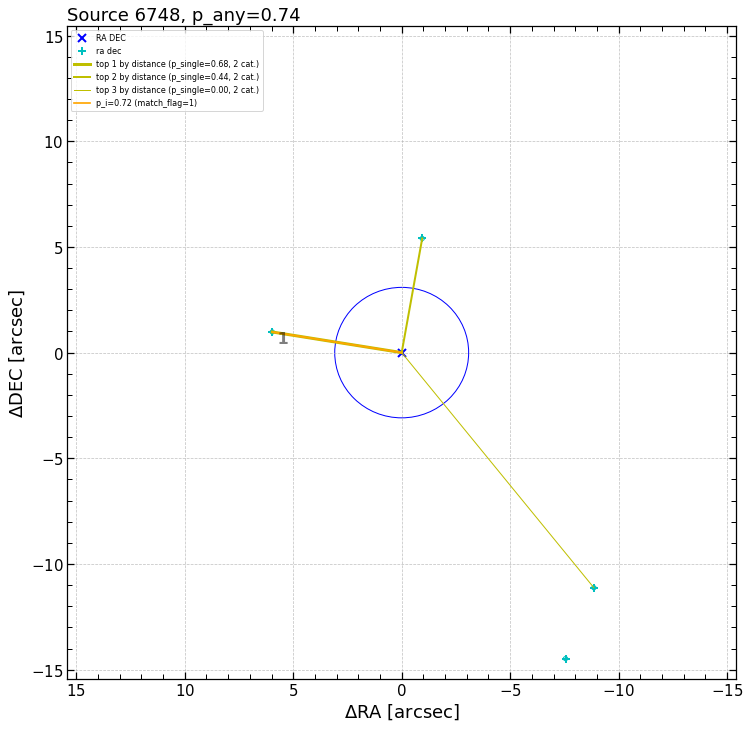

In [37]:
nway.explain(nway_res_dist_only, id = ero_id, **explain_args)[test_columns_explain].head(3)


In [38]:
nway_res.columns

Index(['EROSITA', 'DESI', 'Separation_EROSITA_DESI', 'Separation_max', 'ncat',
       'dist_bayesfactor_uncorrected', 'dist_bayesfactor', 'dist_post',
       'bias_DESI_nnmag_grz', 'bias_DESI_nnmag_grzw1w2',
       'bias_DESI_nnmag_grzw1w2w3w4', 'p_single', 'match_flag',
       'prob_has_match', 'prob_this_match', 'ID', 'RA', 'DEC', 'pos_err',
       'ML_FLUX_0', 'desi_id_true_ctp', 'desi_id', 'ra', 'dec', 'mag_g',
       'mag_r', 'mag_z', 'mag_w1', 'mag_w2', 'mag_w3', 'mag_w4', 'col_gr',
       'col_rz', 'col_gz', 'col_zw1', 'col_rw2', 'col_w1w2', 'col_zw3',
       'col_rw4', 'col_w3w4', 'prior_type', 'nnmag_grzw1w2w3w4',
       'nnmag_grzw1w2w3w4_orig', 'nnmag_grzw1w2', 'nnmag_grzw1w2_orig',
       'nnmag_grz', 'nnmag_grz_orig', 'mag_g_orig', 'mag_r_orig', 'mag_z_orig',
       'mag_w1_orig', 'mag_w2_orig', 'mag_w3_orig', 'mag_w4_orig',
       'col_gr_orig', 'col_rz_orig', 'col_gz_orig', 'col_zw1_orig',
       'col_rw2_orig', 'col_w1w2_orig', 'col_zw3_orig', 'col_rw4_orig',
       'co

# Catalog of best matches

`ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match.pkl` - only the best matches are saved in this catalog, i.e. one DESI object per eROSITA object.
`ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_all_candidates.pkl` - all possible matches are saved in this catalog, i.e. a few DESI object per eROSITA object. The first file is found as a query `match_flag==1` on this catalog.

Description:

* columns from `srcname_fin` to `NH` - original columns of Lockman Hole eROSITA catalog

Cross-match results:

* `nway_desi_id` - DESI coutnerpart. `desi_id` is a concatenation of `release`, `brick` and `objid` of the DESI catalog.
* `nway_Separation_EROSITA_DESI` - separation between the two
* `nway_prob_has_match` - Nway probability of having this match. See calibration figures. Generally, if `nway_prob_has_match`>~0.8, the match is secure, and if `nway_prob_has_match`<~0.2, the match is not secure.
* `nway_prob_this_match` - assuming that eROSITA source has a match, this is the probability of this particular DESI source being a counterpart. 
* `nway_nnmag_grz(w1w2w3w4)` - Magnitude of Neural network photometric classifier. The largre the number, the more likely the source is a counterpart to a generic X-ray source.
* `nway_n_match_flag_0` - number of DESI sources inside 30 arcsec radius of the eROSITA source which have a low probability of being a counterpart: p(secondary)/p(primary)<0.5
* `nway_n_match_flag_2` - the same but for high probability of being a counterpart: p(secondary)/p(primary)>0.5
* `nway_is_duplicated` sources which are **probably** duplicated in the eROSITA catalog. The angular distance to the closest eROSITA  source is less than `1.5*sum(pos_sigma2d)` (approx two `69%` radius).
* `nway_is_confused` - when the sources are not duplicated, but they are assigned to the same DESI source. They are close to each other but not within errors. 

*columns from `desi_release` to `desi_dered_mag_w4` are the columns of the DESI catalog for a `nway_desi_id`.


**Caveats (will be solved in future)**:
* for training NNMAGS, so far not de-reddened magnitudes are used, whereas the match is done with de-reddened magnitudes.
* all magnitudes are used as is, ignoring the SNR of the particular measurements.


In [39]:
save_cols = ['EROSITA', 'desi_id', 'Separation_EROSITA_DESI', 'prob_has_match', 'prob_this_match', 'nnmag_grzw1w2w3w4_orig', 'nnmag_grzw1w2_orig', 'nnmag_grz_orig', 
                'n_match_flag_0', 'n_match_flag_2', 'is_duplicated', 'is_confused']

nway_match_res = nway_res.query('match_flag == 1 ')[save_cols]
nway_match_res.rename(columns = {
                                #'ID':'srcname_fin',
                                'Separation_EROSITA_DESI': 'nway_Separation_EROSITA_DESI',
                                'prob_has_match': 'nway_prob_has_match',
                                'prob_this_match': 'nway_prob_this_match',
                                'nnmag_grzw1w2w3w4_orig': 'nway_nnmag_grzw1w2w3w4',
                                'nnmag_grzw1w2_orig': 'nway_nnmag_grzw1w2',
                                'nnmag_grz_orig': 'nway_nnmag_grz',
                                'desi_id': 'nway_desi_id',
                                'n_match_flag_0': 'nway_n_match_flag_0',
                                'n_match_flag_2': 'nway_n_match_flag_2',
                                'is_duplicated': 'nway_is_duplicated',
                                'is_confused': 'nway_is_confused'
                                }, inplace = True)


#nway_match_res.srcname_fin = nway_match_res.srcname_fin.str.decode('utf-8')
nway_match_res.nway_desi_id = nway_match_res.nway_desi_id.str.decode('utf-8')

nway_match_res = erosita_orig_df.merge(nway_match_res, on = 'EROSITA')
nway_match_res = nway_match_res.merge(desi_pandas_ph, on = 'nway_desi_id')
nway_match_res.drop(columns = ['EROSITA'], inplace = True)
nway_match_res = nway_match_res.sort_values(['srcname_fin'])

nway_match_res.to_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match.gz_pkl', compression='gzip')
nway_match_res

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,nway_desi_id,nway_Separation_EROSITA_DESI,nway_prob_has_match,nway_prob_this_match,nway_nnmag_grzw1w2w3w4,nway_nnmag_grzw1w2,nway_nnmag_grz,nway_n_match_flag_0,nway_n_match_flag_2,nway_is_duplicated,nway_is_confused,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4
1492,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006185,7.077317,154.763934,56.505585,853324209744036352,7.576342,1,0,20.950485,-1.0,0,SDSS J101902.92+563016.4,0.949746,QSO,7.576898,1,0,0,2,16.915001,16.554001,12.382,12.1,5.0,0.7,2,1,1,1237658303814435106,9216733310671409152,7.544174,68469189470,4.058504,3.313348,5.001804,8.110237,132.352465,42.185604,1.670761e-14,1.526396e+20,9011_606779_231,5.167984,0.978923,0.983858,-99.000000,0.969924,0.899362,14,0,False,False,9011,231,606779,154.762154,56.504538,3.362170,4.618722,5.989522,16.031805,20.984790,50.180990,-3.493270,435.342250,248.158630,104.400180,3.761635,0.939089,0.001432,0.000018,21.087423,20.774010,20.520338,19.482046,19.191862,18.247932,NaN
1090,SRGe J101903.4+563325,154.764302,56.556994,154.897407,50.039645,12.232697,16.660557,2.758328e-14,6.850312e-15,34.209091,8.495835,1133.034668,0.0,0.0,0.0,4806,3902,154.766311,56.555705,5.407337,163.025894,0.000029,6.268413e+08,6.270701e+08,0.0,0.0,0.030192,0.007498,6.562579,154.764302,56.556994,-1,-1.000000,0,-1,NaN,-1.0,-1,SDSS J101904.67+563333.2,1.464000,QSO,13.943999,1,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,68265812198,5.407337,4.373272,6.601858,10.704663,132.318989,42.230639,2.122641e-14,1.507868e+20,9011_606779_284,12.929691,0.542276,0.807592,0.957047,0.972121,0.810317,9,0,False,False,9011,284,606779,154.769507,56.559155,4.110681,6.741001,7.775545,18.952187,29.332830,65.296720,371.384800,259.819270,99.752320,72.978060,3.654050,0.866400,0.001278,0.000015,20.872555,20.365770,20.238258,19.300547,18.828358,17.962076,16.075178
2081,SRGe J101911.0+562639,154.795822,56.444182,155.033709,50.112976,7.855049,18.953989,1.654359e-14,3.709296e-15,40.391277,9.056271,2230.516357,0.0,0.0,0.0,4530,3655,154.797830,56.442893,3.409649,142.069946,0.000015,6.268413e+08,6.270701e+08,0.0,0.0,0.018108,0.004060,12.856621,154.795822,56.444182,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,68713641563,3.409649,2.808233,4.239287,6.873844,132.413453,42.140474,1.273093e-14,1.537238e+20,9011_606779_455,15.145586,0.000003,0.846041,-99.000000,0.084824,0.185150,7,0,False,False,9011,455,606779,154.798428,56.448135,0.261824,0.279961,0.433191,0.675604,1.692767,-50.740715,326.340500,409.680970,145.013170,117.516495,4.582493,1.061522,0.001434,0.000018,23.850270,23.811726,23.368849,22.919775,21.924826,NaN,16.215527
2423,SRGe J101914.3+563109,154.809447,56.519165,154.927665,50.080552,18.357738,9.770685,1.461044e-14,4.307066e-15,28.471239,8.393143,1780.289429,0.0,0.0,0.0,7154,6033,154.811456,56.517875,8.171203,102.778427,0.000021,6.268413e+08,6.270701e+08,0.0,0.0,0.015992,0.004714,10.505683,154

catalog of al NWAY results

In [40]:
save_cols = ['EROSITA', 'desi_id', 'Separation_EROSITA_DESI', 'prob_has_match', 'prob_this_match', 'nnmag_grzw1w2w3w4_orig', 'nnmag_grzw1w2_orig', 'nnmag_grz_orig', 
                'n_match_flag_0', 'n_match_flag_2', 'is_duplicated', 'is_confused']

nway_match_res_all_nway = nway_res[save_cols]
nway_match_res_all_nway.rename(columns = {
                                #'ID':'srcname_fin',
                                'Separation_EROSITA_DESI': 'nway_Separation_EROSITA_DESI',
                                'prob_has_match': 'nway_prob_has_match',
                                'prob_this_match': 'nway_prob_this_match',
                                'nnmag_grzw1w2w3w4_orig': 'nway_nnmag_grzw1w2w3w4',
                                'nnmag_grzw1w2_orig': 'nway_nnmag_grzw1w2',
                                'nnmag_grz_orig': 'nway_nnmag_grz',
                                'desi_id': 'nway_desi_id',
                                'n_match_flag_0': 'nway_n_match_flag_0',
                                'n_match_flag_2': 'nway_n_match_flag_2',
                                'is_duplicated': 'nway_is_duplicated',
                                'is_confused': 'nway_is_confused'
                                }, inplace = True)


#nway_match_res_all_nway.srcname_fin = nway_match_res_all_nway.srcname_fin.str.decode('utf-8')
nway_match_res_all_nway.nway_desi_id = nway_match_res_all_nway.nway_desi_id.str.decode('utf-8')

nway_match_res_all_nway = erosita_orig_df.merge(nway_match_res_all_nway, on = 'EROSITA')
nway_match_res_all_nway = nway_match_res_all_nway.merge(desi_pandas_ph, on = 'nway_desi_id')
nway_match_res_all_nway.drop(columns = ['EROSITA'], inplace = True)
nway_match_res_all_nway = nway_match_res_all_nway.sort_values(['srcname_fin', 'nway_prob_this_match'], ascending = [True, False])

nway_match_res_all_nway.to_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_all_candidates.gz_pkl', compression='gzip')
nway_match_res_all_nway

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,nway_desi_id,nway_Separation_EROSITA_DESI,nway_prob_has_match,nway_prob_this_match,nway_nnmag_grzw1w2w3w4,nway_nnmag_grzw1w2,nway_nnmag_grz,nway_n_match_flag_0,nway_n_match_flag_2,nway_is_duplicated,nway_is_confused,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4
25741,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006185,7.077317,154.763934,56.505585,853324209744036352,7.576342,1,0,20.950485,-1.0,0,SDSS J101902.92+563016.4,0.949746,QSO,7.576898,1,0,0,2,16.915001,16.554001,12.382,12.1,5.0,0.7,2,1,1,1237658303814435106,9216733310671409152,7.544174,68469189470,4.058504,3.313348,5.001804,8.110237,132.352465,42.185604,1.670761e-14,1.526396e+20,9011_606779_231,5.167984,0.978923,9.838582e-01,-99.000000,0.969924,0.899362,14,0,False,False,9011,231,606779,154.762154,56.504538,3.362170,4.618722,5.989522,16.031805,20.984790,50.180990,-3.49327,435.342250,248.158630,104.400180,3.761635,0.939089,0.001432,0.000018,21.087423,20.774010,20.520338,19.482046,19.191862,18.247932,NaN
25742,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006185,7.077317,154.763934,56.505585,853324209744036352,7.576342,1,0,20.950485,-1.0,0,SDSS J101902.92+563016.4,0.949746,QSO,7.576898,1,0,0,2,16.915001,16.554001,12.382,12.1,5.0,0.7,2,1,1,1237658303814435106,9216733310671409152,7.544174,68469189470,4.058504,3.313348,5.001804,8.110237,132.352465,42.185604,1.670761e-14,1.526396e+20,9011_606779_263,6.306570,0.978923,1.504417e-02,-99.000000,0.551578,0.300600,14,0,False,False,9011,263,606779,154.767108,56.505610,0.075512,0.175725,0.867316,16.579830,15.693951,-18.334469,-1184.22920,435.054320,134.892380,56.584290,3.649384,0.948426,0.001390,0.000017,25.208895,24.323198,22.618357,19.445549,19.507292,NaN,NaN
25743,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006185,7.077317,154.763934,56.505585,853324209744036352,7.576342,1,0,20.950485,-1.0,0,SDSS J101902.92+563016.4,0.949746,QSO,7.576898,1,0,0,2,16.915001,16.554001,12.382,12.1,5.0,0.7,2,1,1,1237658303814435106,9216733310671409152,7.544174,68469189470,4.058504,3.313348,5.001804,8.110237,132.352465,42.185604,1.670761e-14,1.526396e+20,9011_606779_239,4.917724,0.978923,6.572771e-04,0.020648,0.027142,0.558110,14,0,False,False,9011,239,606779,154.763287,56.506903,0.321437,1.060153,4.870105,2.290698,1.339155,55.415050,413.59406,631.809270,211.408690,105.205840,4.324362,1.051834,0.001422,0.000018,23.636383,22.371996,20.745030,21.594591,22.179552,18.140211,15.958293
25744,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.

# Catalog of best matches (distance only)

`ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_dist_only.pkl` - only the best matches are saved in this catalog, i.e. one DESI object per eROSITA object.
`ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_all_candidates_dist_only.pkl` - all possible matches are saved in this catalog, i.e. a few DESI object per eROSITA object. The first file is found as a query `match_flag==1` on this catalog.

Description:

* columns from `srcname_fin` to `NH` - original columns of Lockman Hole eROSITA catalog

Cross-match results:

* `nway_desi_id` - DESI coutnerpart. `desi_id` is a concatenation of `release`, `brick` and `objid` of the DESI catalog.
* `nway_Separation_EROSITA_DESI` - separation between the two
* `nway_prob_has_match` - Nway probability of having this match. See calibration figures. Generally, if `nway_prob_has_match`>~0.8, the match is secure, and if `nway_prob_has_match`<~0.2, the match is not secure.
* `nway_prob_this_match` - assuming that eROSITA source has a match, this is the probability of this particular DESI source being a counterpart. 
* `nway_n_match_flag_0` - number of DESI sources inside 30 arcsec radius of the eROSITA source which have a low probability of being a counterpart: p(secondary)/p(primary)<0.5
* `nway_n_match_flag_2` - the same but for high probability of being a counterpart: p(secondary)/p(primary)>0.5

*columns from `desi_release` to `desi_dered_mag_w4` are the columns of the DESI catalog for a `nway_desi_id`.


In [41]:
save_cols = ['EROSITA', 'desi_id', 'Separation_EROSITA_DESI', 'prob_has_match', 'prob_this_match',
                'n_match_flag_0', 'n_match_flag_2']

nway_match_res_dist_only = nway_res_dist_only.query('match_flag == 1 ')[save_cols]
nway_match_res_dist_only.rename(columns = {
                                #'ID':'srcname_fin',
                                'Separation_EROSITA_DESI': 'nway_Separation_EROSITA_DESI',
                                'prob_has_match': 'nway_prob_has_match',
                                'prob_this_match': 'nway_prob_this_match',
                                'desi_id': 'nway_desi_id',
                                'n_match_flag_0': 'nway_n_match_flag_0',
                                'n_match_flag_2': 'nway_n_match_flag_2',
                                }, inplace = True)


#nway_match_res_dist_only.srcname_fin = nway_match_res_dist_only.srcname_fin.str.decode('utf-8')
nway_match_res_dist_only.nway_desi_id = nway_match_res_dist_only.nway_desi_id.str.decode('utf-8')

nway_match_res_dist_only = erosita_orig_df.merge(nway_match_res_dist_only, on = 'EROSITA')
nway_match_res_dist_only = nway_match_res_dist_only.merge(desi_pandas_ph, on = 'nway_desi_id')
nway_match_res_dist_only.drop(columns = ['EROSITA'], inplace = True)
nway_match_res_dist_only = nway_match_res_dist_only.sort_values(['srcname_fin'])

nway_match_res_dist_only.to_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_desi_nway_match_dist_only.pkl', compression='gzip')
nway_match_res_dist_only

,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,nway_desi_id,nway_Separation_EROSITA_DESI,nway_prob_has_match,nway_prob_this_match,nway_n_match_flag_0,nway_n_match_flag_2,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4
1491,SRGe J101903.3+563020,154.763934,56.505585,154.966043,50.066118,9.267930,15.858959,2.171120e-14,5.650445e-15,28.800014,7.495345,1211.871216,0.0,0.0,0.0,6207,5146,154.765943,56.504295,4.058504,102.778427,0.000023,6.268413e+08,6.270701e+08,0.0,0.0,0.023765,0.006185,7.077317,154.763934,56.505585,853324209744036352,7.576342,1,0,20.950485,-1.0,0,SDSS J101902.92+563016.4,0.949746,QSO,7.576898,1,0,0,2,16.915001,16.554001,12.382,12.1,5.0,0.7,2,1,1,1237658303814435106,9216733310671409152,7.544174,68469189470,4.058504,3.313348,5.001804,8.110237,132.352465,42.185604,1.670761e-14,1.526396e+20,9011_606779_239,4.917724,0.739579,0.379585,12,2,9011,239,606779,154.763287,56.506903,0.321437,1.060153,4.870105,2.290698,1.339155,55.415050,413.594060,631.809270,211.408690,105.205840,4.324362,1.051834,0.001422,0.000018,23.636383,22.371996,20.745030,21.594591,22.179552,18.140211,15.958293
1089,SRGe J101903.4+563325,154.764302,56.556994,154.897407,50.039645,12.232697,16.660557,2.758328e-14,6.850312e-15,34.209091,8.495835,1133.034668,0.0,0.0,0.0,4806,3902,154.766311,56.555705,5.407337,163.025894,0.000029,6.268413e+08,6.270701e+08,0.0,0.0,0.030192,0.007498,6.562579,154.764302,56.556994,-1,-1.000000,0,-1,NaN,-1.0,-1,SDSS J101904.67+563333.2,1.464000,QSO,13.943999,1,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,68265812198,5.407337,4.373272,6.601858,10.704663,132.318989,42.230639,2.122641e-14,1.507868e+20,9011_606779_218,9.594825,0.317792,0.451884,8,1,9011,218,606779,154.760218,56.555567,0.269704,0.338683,0.553034,-0.120784,0.548857,-18.639507,529.034200,412.783360,279.548680,79.561584,4.304590,1.023274,0.001280,0.000016,23.830263,23.613194,23.108260,NaN,23.148098,NaN,15.691029
2080,SRGe J101911.0+562639,154.795822,56.444182,155.033709,50.112976,7.855049,18.953989,1.654359e-14,3.709296e-15,40.391277,9.056271,2230.516357,0.0,0.0,0.0,4530,3655,154.797830,56.442893,3.409649,142.069946,0.000015,6.268413e+08,6.270701e+08,0.0,0.0,0.018108,0.004060,12.856621,154.795822,56.444182,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,68713641563,3.409649,2.808233,4.239287,6.873844,132.413453,42.140474,1.273093e-14,1.537238e+20,9011_606779_455,15.145586,0.000023,0.998722,7,0,9011,455,606779,154.798428,56.448135,0.261824,0.279961,0.433191,0.675604,1.692767,-50.740715,326.340500,409.680970,145.013170,117.516495,4.582493,1.061522,0.001434,0.000018,23.850270,23.811726,23.368849,22.919775,21.924826,NaN,16.215527
2422,SRGe J101914.3+563109,154.809447,56.519165,154.927665,50.080552,18.357738,9.770685,1.461044e-14,4.307066e-15,28.471239,8.393143,1780.289429,0.0,0.0,0.0,7154,6033,154.811456,56.517875,8.171203,102.778427,0.000021,6.268413e+08,6.270701e+08,0.0,0.0,0.015992,0.004714,10.505683,154.809447,56.519165,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,0,0,0,15.304000,14.829000,11.744,29.8,19.2,5.3,1,2,0,1237658303814500601,0,6.706048,68415172650,8.171203,6.563016,9.907477,16.064602,132.373189,42.20